In [1]:
# 필요한 라이브러리 및 모듈 불러오기
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import sys
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append(r"C:\Users\dhshs\Documents\ganomaly_global")
sys.path.append(r"C:\Users\dhshs\Documents\ganomaly_global\lib")
from lib.model import Ganomaly  # lib/model.py에서 제공되는 GANomaly 모델 사용
from lib.evaluate import evaluate, roc  # evaluate.py에서 제공되는 평가 함수 사용
from lib.visualizer import Visualizer  # visualizer.py에서 제공되는 시각화 클래스 사용
from options import Options  # 옵션 파일

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
class CustomDataset(Dataset):
    def __init__(self, directory, label, transform=None):
        self.directory = directory
        self.transform = transform
        self.label = label  # 레이블 정보 추가
        self.images = [img for img in os.listdir(directory) if img.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.images[idx])
        image = Image.open(img_path).convert("L")  # 흑백 이미지로 변환

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(self.label, dtype=torch.long)  # 레이블 포함하여 반환


In [3]:
# 데이터셋 경로 설정
normal_train_dir = r"C:\Users\dhshs\Documents\ganomaly_global\dataset\ELPV\mono\train\0.normal"
abnormal_test_dir = r"C:\Users\dhshs\Documents\ganomaly_global\dataset\ELPV\mono\test\1.abnormal"
normal_test_dir = r"C:\Users\dhshs\Documents\ganomaly_global\dataset\ELPV\mono\test\0.normal"

# 데이터 전처리 및 데이터 로더 설정
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
])

# 학습 및 테스트 데이터셋 생성
train_dataset = CustomDataset(normal_train_dir, label=0, transform=transform)  # 학습 데이터셋 로드 (normal만)
normal_test_dataset = CustomDataset(normal_test_dir, label=0, transform=transform)  # 테스트 데이터셋 로드 (normal)
abnormal_test_dataset = CustomDataset(abnormal_test_dir, label=1, transform=transform)  # 테스트 데이터셋 로드 (abnormal)

# 두 개의 테스트 데이터셋을 합침
from torch.utils.data import ConcatDataset

test_dataset = ConcatDataset([normal_test_dataset, abnormal_test_dataset])

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


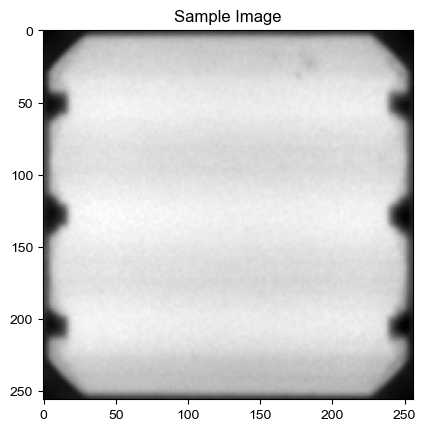

In [4]:
import matplotlib.pyplot as plt
import torch

# LaTeX 사용 비활성화
plt.rcParams["text.usetex"] = False

# 데이터 로더에서 샘플 하나 가져오기
sample_image = next(iter(train_loader))

# 첫 번째 이미지 선택 (배치 크기만큼 가져오므로 첫 번째만 선택)
sample_image = sample_image[0][0].squeeze(0)  # 배치 차원과 채널 차원을 제거

# 이미지 시각화
plt.rcParams["font.family"] = "Arial"
plt.imshow(sample_image, cmap='gray')
plt.title("Sample Image")
plt.show()


In [26]:
# Jupyter Notebook의 매개변수를 무시하도록 설정
sys.argv = ['']

# 옵션 설정
opt = Options().parse()
opt.isize = 256  # 데이터의 이미지 크기
opt.nc = 1       # 흑백 이미지이므로 채널 수를 1로 설정
opt.batchsize = 32  # 배치 크기 설정
opt.save_test_images = True  # 테스트 이미지 저장 설정
opt.display = True  # 실시간 시각화 설정
opt.use_context_pred = True # 마스킹 설정

In [27]:
dataloader = {'train': train_loader, 'test': test_loader}  # 데이터 로더 설정

# GANomaly 모델 생성
model = Ganomaly(opt, dataloader)

Setting up a new session...


In [ ]:
model.train()

In [8]:
model.save_weights(39)

> #### 추가 학습

In [37]:
# Jupyter Notebook의 매개변수를 무시하도록 설정
sys.argv = ['']

# 옵션 설정
opt = Options().parse()
opt.isize = 256  # 데이터의 이미지 크기
opt.nc = 1       # 흑백 이미지이므로 채널 수를 1로 설정
opt.batchsize = 32  # 배치 크기 설정
opt.save_test_images = True  # 테스트 이미지 저장 설정
opt.display = True  # 실시간 시각화 설정
opt.niter = 50
opt.resume = {
    'netg_path': r"C:\Users\dhshs\Documents\ganomaly_global\project\output(use masking 가중치 0.5)\ganomaly\ELPV\train\weights\epoch50_netG.pth",
    'netd_path': r"C:\Users\dhshs\Documents\ganomaly_global\project\output(use masking 가중치 0.5)\ganomaly\ELPV\train\weights\epoch50_netD.pth"
}
opt.use_context_pred = True # 마스킹 설정

In [38]:
dataloader = {'train': train_loader, 'test': test_loader}  # 데이터 로더 설정

# GANomaly 모델 생성
model = Ganomaly(opt, dataloader)

Setting up a new session...



Loading pre-trained networks.
	Loaded pre-trained weights.



In [7]:
model.train()

>> Training model Ganomaly.


  0%|          | 0/12 [00:00<?, ?it/s]c:\Users\dhshs\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\dhshs\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [41/50], Generator Loss: 2.5356, Discriminator Loss: 0.7325
Epoch [41/50] - Avg Generator Loss: 2.5356, Avg Discriminator Loss: 0.7325, Best AUC: 0.6329
   Avg Run Time (ms/batch): 34.000 roc: 0.633 max roc: 0.633


Epoch [42/50], Generator Loss: 2.0841, Discriminator Loss: 0.0004
Epoch [42/50] - Avg Generator Loss: 2.0841, Avg Discriminator Loss: 0.0004, Best AUC: 0.6329
   Avg Run Time (ms/batch): 5.554 roc: 0.621 max roc: 0.633


Epoch [43/50], Generator Loss: 2.0703, Discriminator Loss: 0.0003
Epoch [43/50] - Avg Generator Loss: 2.0703, Avg Discriminator Loss: 0.0003, Best AUC: 0.6784
   Avg Run Time (ms/batch): 4.781 roc: 0.678 max roc: 0.678


Epoch [44/50], Generator Loss: 2.0023, Discriminator Loss: 0.0004
Epoch [44/50] - Avg Generator Loss: 2.0023, Avg Discriminator Loss: 0.0004, Best AUC: 0.6784
   Avg Run Time (ms/batch): 8.678 roc: 0.591 max roc: 0.678


Epoch [45/50], Generator Loss: 1.9665, Discriminator Loss: 0.0003
Epoch [45/50] - Avg Generator Loss: 1.9665, Avg Discriminator Loss: 0.0003, Best AUC: 0.6784
   Avg Run Time (ms/batch): 8.060 roc: 0.639 max roc: 0.678


Epoch [46/50], Generator Loss: 2.1236, Discriminator Loss: 0.0005
Epoch [46/50] - Avg Generator Loss: 2.1236, Avg Discriminator Loss: 0.0005, Best AUC: 0.6784
   Avg Run Time (ms/batch): 9.002 roc: 0.658 max roc: 0.678


Epoch [47/50], Generator Loss: 1.9138, Discriminator Loss: 12.4634
Epoch [47/50] - Avg Generator Loss: 1.9138, Avg Discriminator Loss: 12.4634, Best AUC: 0.6784
   Avg Run Time (ms/batch): 9.318 roc: 0.677 max roc: 0.678


Epoch [48/50], Generator Loss: 1.8035, Discriminator Loss: 0.2194
Epoch [48/50] - Avg Generator Loss: 1.8035, Avg Discriminator Loss: 0.2194, Best AUC: 0.6784
   Avg Run Time (ms/batch): 6.889 roc: 0.621 max roc: 0.678


Epoch [49/50], Generator Loss: 1.8994, Discriminator Loss: 0.0113
Epoch [49/50] - Avg Generator Loss: 1.8994, Avg Discriminator Loss: 0.0113, Best AUC: 0.6784
   Avg Run Time (ms/batch): 7.863 roc: 0.646 max roc: 0.678


Epoch [50/50], Generator Loss: 1.9731, Discriminator Loss: 0.0006
Epoch [50/50] - Avg Generator Loss: 1.9731, Avg Discriminator Loss: 0.0006, Best AUC: 0.6784
   Avg Run Time (ms/batch): 6.554 roc: 0.556 max roc: 0.678
>> Training model Ganomaly.[Done]


In [ ]:
model.save_weights(49)

In [11]:
def evaluate_and_visualize(model, dataloader, device, threshold=None):
    """
    Evaluate the model and visualize the results, including test(normal) and test(anomaly) distributions.
    This function integrates the calculation of novelty scores.
    """
    model.netg.eval()  # Set the model to evaluation mode
    novelty_scores = []
    labels = []

    # Calculate novelty scores
    with torch.no_grad():
        for data in dataloader:
            inputs, targets = data[0].to(device), data[1].to(device)

            # Forward pass through NetG
            _, latent_i, latent_o = model.netg(inputs)

            # Calculate novelty score
            scores = torch.mean((latent_i - latent_o) ** 2, dim=1).cpu().numpy().flatten()
            novelty_scores.extend(scores)
            labels.extend(targets.cpu().numpy())

    # Convert to numpy arrays
    novelty_scores = np.array(novelty_scores)
    labels = np.array(labels)

    # Find threshold if not provided
    if threshold is None:
        fpr, tpr, thresholds = roc_curve(labels, novelty_scores)
        optimal_idx = np.argmax(tpr - fpr)
        threshold = thresholds[optimal_idx]

    # Generate predictions
    preds = (novelty_scores > threshold).astype(int)

    # Separate test scores into normal and anomaly based on true labels
    normal_scores = novelty_scores[labels == 0]
    anomaly_scores = novelty_scores[labels == 1]

    # Plot Novelty Scores Distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(normal_scores, color="green", label="Test (Normal)", kde=True, bins=30, stat="density", alpha=0.5)
    sns.histplot(anomaly_scores, color="red", label="Test (Anomalous)", kde=True, bins=30, stat="density", alpha=0.5)
    plt.axvline(x=threshold, color="black", linestyle="--", label="Threshold")
    plt.title("Novelty Scores Distribution")
    plt.xlabel("Novelty Score")
    plt.ylabel("Density")
    plt.xlim(0, 1)  # X-axis range limited to 0-1
    plt.legend()
    plt.show()

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, preds))

    return threshold


c:\Users\dhshs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dhshs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


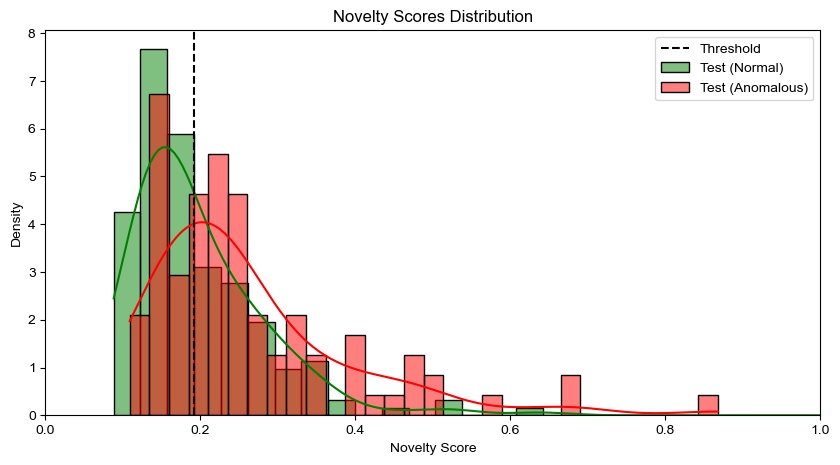


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.62      0.69       177
           1       0.48      0.67      0.56        94

    accuracy                           0.63       271
   macro avg       0.63      0.64      0.62       271
weighted avg       0.68      0.63      0.64       271

Optimal Threshold: 0.19174593687057495


In [12]:
# Evaluate and visualize
optimal_threshold = evaluate_and_visualize(model, test_loader, device)
print(f"Optimal Threshold: {optimal_threshold}")


In [13]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def evaluate_test_dataset(model, test_loader, threshold, device="cuda"):
    """
    설정된 임계값을 사용하여 test dataset에 대해 이상치를 판별하고 평가합니다.

    Args:
        model: GANomaly 모델 인스턴스
        test_loader: test sample을 포함한 DataLoader
        threshold (float): 이상치 판별을 위한 임계값
        device (str): 연산에 사용할 장치 (기본값: "cuda")
    """
    model.netg.eval()
    novelty_scores = []
    true_labels = []
    predictions = []

    with torch.no_grad():
        for data in test_loader:
            # 데이터 로드 및 device로 이동
            inputs, labels = data[0].to(device), data[1].to(device)
            if inputs.dim() == 3:
                inputs = inputs.unsqueeze(0)
            
            # latent 벡터 생성 및 novelty score 계산
            _, latent_i, latent_o = model.netg(inputs)
            scores = torch.mean((latent_i - latent_o) ** 2, dim=1)
            novelty_scores.extend(scores.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # 임계값을 사용해 이상 여부를 예측 (0: 정상, 1: 이상)
            pred = (scores >= threshold).int()
            predictions.extend(pred.cpu().numpy())

    # numpy 배열로 변환 및 차원 축소
    true_labels = np.array(true_labels).astype(int).flatten()
    predictions = np.array(predictions).astype(int).flatten()
    novelty_scores = np.array(novelty_scores).flatten()

    # Confusion matrix 생성 및 시각화
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks([0, 1], ["Normal", "Anomaly"])
    plt.yticks([0, 1], ["Normal", "Anomaly"])

    # 각 셀에 샘플 개수를 텍스트로 추가
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.show()

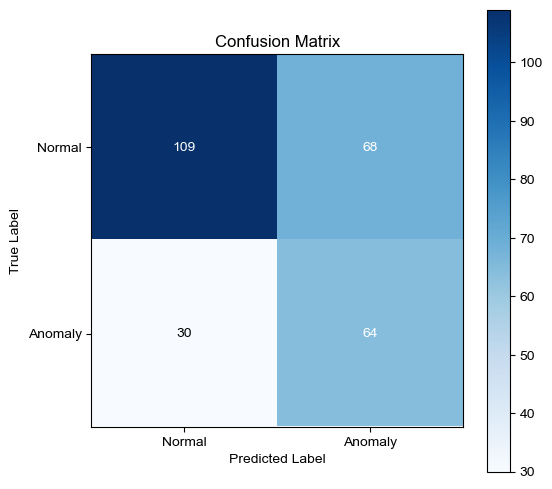

In [14]:
# 사용 예시: test_loader를 입력으로 전달하고 threshold 적용
evaluate_test_dataset(model, test_loader, optimal_threshold, device=device)

---

In [5]:
# Jupyter Notebook의 매개변수를 무시하도록 설정
sys.argv = ['']

# 옵션 설정
opt = Options().parse()
opt.isize = 256  # 데이터의 이미지 크기
opt.nc = 1       # 흑백 이미지이므로 채널 수를 1로 설정
opt.batchsize = 32  # 배치 크기 설정
opt.save_test_images = True  # 테스트 이미지 저장 설정
opt.display = True  # 실시간 시각화 설정
opt.niter = 50
opt.resume = {
    'netg_path': r"C:\Users\dhshs\Documents\ganomaly_global\project\output(use masking 가중치 0.5)\ganomaly\ELPV\train\weights\epoch50_netG.pth",
    'netd_path': r"C:\Users\dhshs\Documents\ganomaly_global\project\output(use masking 가중치 0.5)\ganomaly\ELPV\train\weights\epoch50_netD.pth"
}
opt.use_context_pred = True # 마스킹 설정

In [8]:
dataloader = {'train': train_loader, 'test': test_loader}  # 데이터 로더 설정

# GANomaly 모델 생성
model = Ganomaly(opt, dataloader)

Setting up a new session...



Loading pre-trained networks.
	Loaded pre-trained weights.



  0%|          | 0/9 [00:00<?, ?it/s]

Normal Image 1


C:\Users\dhshs\AppData\Local\Temp\ipykernel_23228\68670738.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  heatmap_resized = plt.cm.get_cmap(colormap)(heatmap)[:, :, :3]  # Apply colormap


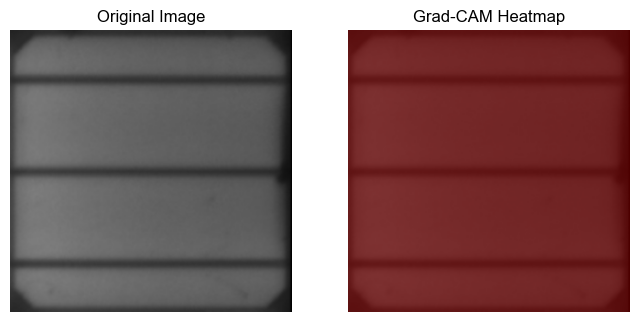

Normal Image 2


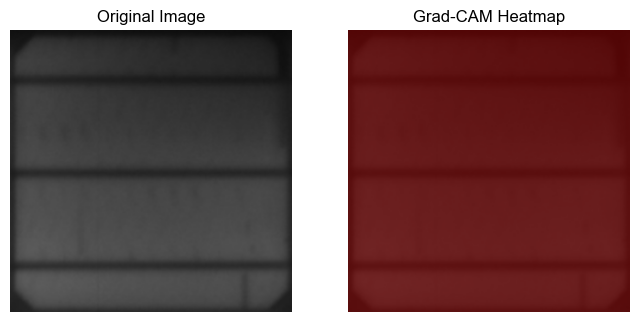

Normal Image 3


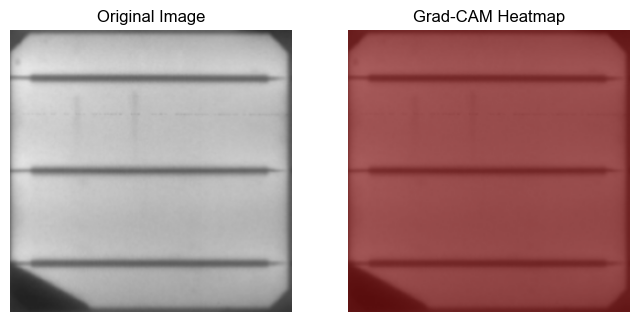

Normal Image 4


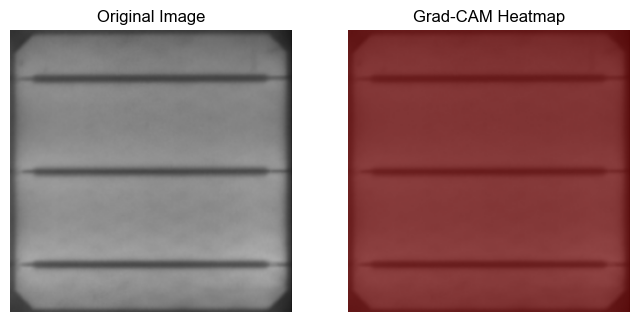

Normal Image 5


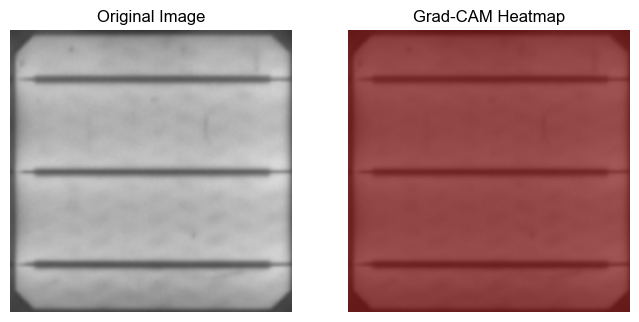

 56%|█████▌    | 5/9 [00:03<00:02,  1.76it/s]

Anomaly Image 1


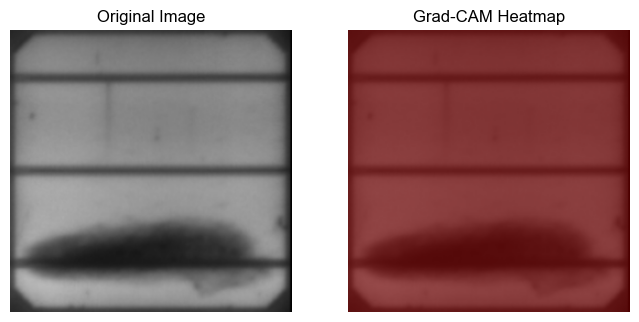

Anomaly Image 2


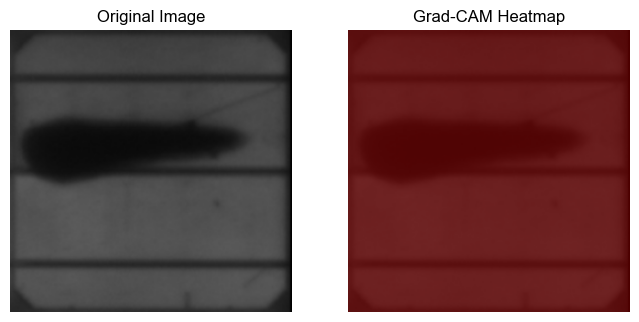

Anomaly Image 3


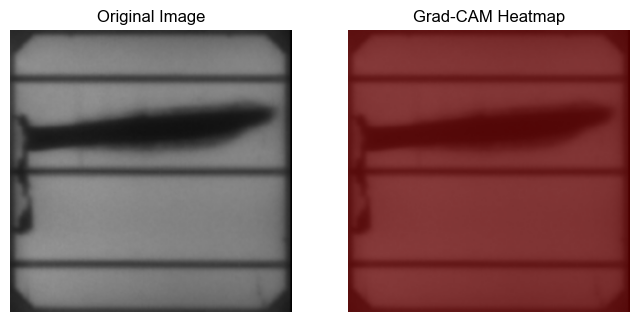

Anomaly Image 4


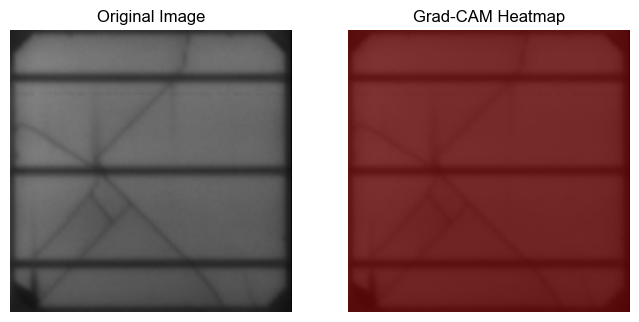

Anomaly Image 5


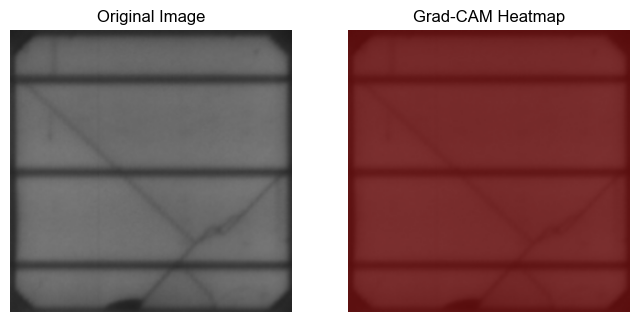

 56%|█████▌    | 5/9 [00:04<00:03,  1.08it/s]


In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torch.nn.functional import relu
from tqdm import tqdm

# Grad-CAM 클래스 정의
class GradCAM:
    def __init__(self, model, target_layer):
        """
        Initialize Grad-CAM for the given model and target layer.
        Args:
            model: PyTorch model
            target_layer: Layer where Grad-CAM is applied
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        """
        Register hooks to capture gradients and activations.
        """
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, x):
        """
        Generate Grad-CAM heatmap for the given input.
        Args:
            x: Input image tensor
        Returns:
            heatmap: Grad-CAM heatmap
        """
        self.model.zero_grad()
        classifier_output, _ = self.model(x)  # Get classifier output
        loss = classifier_output.sum()  # Sum of all logits
        loss.backward()

        # Gradients and activations
        gradients = self.gradients.cpu().data.numpy()
        activations = self.activations.cpu().data.numpy()

        # Compute weights and heatmap
        weights = np.mean(gradients, axis=(2, 3))  # Global average pooling
        heatmap = np.zeros(activations.shape[2:], dtype=np.float32)

        for i, w in enumerate(weights[0]):
            heatmap += w * activations[0, i, :, :]

        # Apply ReLU and normalize
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)  # Normalize
        return heatmap

def visualize_heatmap(image, heatmap, alpha=0.6, colormap='jet'):
    """
    Overlay heatmap on the original image.
    Args:
        image: Original image (numpy array or PIL image)
        heatmap: Grad-CAM heatmap (numpy array)
        alpha: Transparency level of heatmap overlay
        colormap: Matplotlib colormap
    """
    # Normalize image to 3-channel if grayscale
    if len(image.shape) == 2:  # Grayscale image
        image = np.stack([image] * 3, axis=-1)
    heatmap_resized = plt.cm.get_cmap(colormap)(heatmap)[:, :, :3]  # Apply colormap
    heatmap_resized = (heatmap_resized * 255).astype(np.uint8)  # Scale to 0-255
    overlay = (image * (1 - alpha) + heatmap_resized * alpha).astype(np.uint8)  # Overlay

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image.astype(np.uint8), cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")
    plt.show()

# Grad-CAM 준비
target_layer = model.netd.classifier[-1]  # Discriminator의 마지막 Sigmoid 레이어
grad_cam = GradCAM(model.netd, target_layer)

# 테스트 데이터에서 Grad-CAM 시각화
model.netd.eval()
num_normals = 0
num_anomalies = 0

data_iter = iter(dataloader['test'])
for inputs, labels in tqdm(data_iter):
    inputs = inputs.to(model.device)
    labels = labels.to(model.device)

    for i in range(inputs.size(0)):
        if num_normals >= 5 and num_anomalies >= 5:
            break

        input_image = inputs[i].unsqueeze(0)  # Add batch dimension
        heatmap = grad_cam(input_image)  # Grad-CAM 적용
        input_image_np = (input_image.squeeze().cpu().numpy() * 255).astype(np.uint8)

        # 시각화
        if labels[i] == 0 and num_normals < 5:  # Normal image
            print(f"Normal Image {num_normals + 1}")
            visualize_heatmap(input_image_np, heatmap)
            num_normals += 1
        elif labels[i] == 1 and num_anomalies < 5:  # Anomalous image
            print(f"Anomaly Image {num_anomalies + 1}")
            visualize_heatmap(input_image_np, heatmap)
            num_anomalies += 1

    if num_normals >= 5 and num_anomalies >= 5:
        break
